In [74]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud


api_key = '' # API key generated from console google
channel_ids = ['UC-lHJZR3Gqxm24_Vd_AJ5Yw',  # Channel id of Pewdiepie
               # more channel can be added 
               ]

api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)


def get_channel_stats(youtube, channel_ids):
    """
    Get channel stats
    
    Params:
    ------
    youtube: build object of Youtube API
    channel_ids: list of channel IDs
    
    Returns:
    ------
    dataframe with all channel stats for each channel ID
    
    """

    # Creating a list/container for the column data we need from the JSON because not its data is necessary
    all_data = []

    # Making the API Request
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id="UC-lHJZR3Gqxm24_Vd_AJ5Yw" # Channel id of Pewdiepie
    )
    response = request.execute()
    
    # loop through items to get channelName, subscribers, views, totalVideos, playlistId
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
                }
        all_data.append(data)

    return(pd.DataFrame(all_data))

channel_stats = get_channel_stats(youtube, channel_ids)

channel_stats



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rafael\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rafael\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,channelName,subscribers,views,totalVideos,playlistId
0,PewDiePie,111000000,29310231552,4765,UU-lHJZR3Gqxm24_Vd_AJ5Yw


In [75]:




# playlist_id = "UUoOae5nYA7VqaXzerajD0lg" # Ali Abdaal

playlist_id = 'UU-lHJZR3Gqxm24_Vd_AJ5Yw' # Play-list id of Pewdiepie

def get_video_ids(youtube, playlist_id):
    """
    Get channel stats
    
    Params:
    ------
    youtube: build object of Youtube API
    channel_ids: list of play list ids
    
    Returns:
    ------
    dataframe with all play list stats for each channel ID
    
    """

    video_ids = [] # Creating containers/list for the video_ids

    # Making the API Request
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id
    )
    response = request.execute()

    # Access all the JSON files to get the certain JSON data only
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
    next_page_token = response.get('nextPageToken')

    # Get all the video id because the default of maxResults when not assign is return only 5, so edit it manually
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="contentDetails",
            playlistId=playlist_id,
            maxResults = 500,
            pageToken = next_page_token)
        response = request.execute()

        # Get the contetDetails and videoID
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')

    
    return video_ids # Return all the data you place in the video_ids created in the list inside of the function

video_ids = get_video_ids(youtube, playlist_id)

len(video_ids)



4578

In [76]:

def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

video_df = get_video_details(youtube, video_ids)

len(video_df)

4578

## Data pre-processing

In [77]:
# check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount          True
likeCount          True
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [78]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [79]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')
video_df[['durationSecs', 'duration']] 

,durationSecs,duration
0,0 days 00:29:30,PT29M30S
1,0 days 00:15:48,PT15M48S
2,0 days 00:32:24,PT32M24S
3,0 days 00:15:45,PT15M45S
4,0 days 00:09:03,PT9M3S
...,...,...
4573,0 days 00:09:39,PT9M39S
4574,0 days 00:08:42,PT8M42S
4575,0 days 00:03:13,PT3M13S
4576,0 days 00:05:37,PT5M37S


In [80]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))
video_df


,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,TwtjzPZj2XY,PewDiePie,I brought the boy to his homeland,Go to https://ridge.com/pewdiepie to get up to...,"[pewdiepie, pewds, pewdie]",2024-06-04 16:00:44+00:00,1949009.0,150152.0,NaN,5898.0,PT29M30S,hd,false,Tuesday,0 days 00:29:30,3
1,3CqDamkcXPk,PewDiePie,YouTubers are ruining Japan,BOGO FREE #GFUEL (affiliate) ➡️🥤 https://affil...,"[pewdiepie, pewds, pewdie, Japan, PewDiePie Ja...",2024-05-22 16:30:00+00:00,2417057.0,129372.0,NaN,6425.0,PT15M48S,hd,false,Wednesday,0 days 00:15:48,6
2,Pl6KcYzyvJE,PewDiePie,I went to the holy land..,Get exclusive NordVPN deal here ➵ https://Nord...,"[pewdiepie, pewds, pewdie]",2024-05-13 17:00:26+00:00,2553562.0,130899.0,NaN,4453.0,PT32M24S,hd,false,Monday,0 days 00:32:24,3
3,KvN8U6cqiu0,PewDiePie,Reacting to my Wife's Memes,Get exclusive NordVPN deal here ➵ https://Nord...,"[pewdiepie, pewds, pewdie, marzia, pewdiepie m...",2024-04-30 17:31:11+00:00,1971676.0,142554.0,NaN,2960.0,PT15M45S,hd,false,Tuesday,0 days 00:15:45,9
4,17Rw1Lu_iWA,PewDiePie,Studied the Slinky for 52 Days Straight..,🥤Gfuel's BOGO on now!!! https://affiliateshop....,"[pewdiepie, pewds, pewdie]",2024-04-25 17:00:02+00:00,1685516.0,117745.0,NaN,3873.0,PT9M3S,hd,false,Thursday,0 days 00:09:03,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4573,hC7c1fhW1YM,PewDiePie,Dual Minecraft Lets Play! Episode [003] - Expl...,Thanks for SUBSCRIBING!\r\nSub 2 Xebaz: http:/...,"[minecraft, mindcraft, mind, dual, commentary,...",2010-12-19 19:03:50+00:00,834076.0,11731.0,NaN,1664.0,PT9M39S,hd,false,Sunday,0 days 00:09:39,31
4574,XONXcdJ0278,PewDiePie,Dual Minecraft Lets Play! Episode [002] - New ...,Thanks for SUBSCRIBING!\r\n\r\nPewDiePie fails...,"[Military, Penis, exploded, in, Xebaz, face, m...",2010-12-19 00:24:52+00:00,1965752.0,33524.0,NaN,4654.0,PT8M42S,hd,false,Sunday,0 days 00:08:42,35
4575,lUtoLyyeOwQ,PewDiePie,Call of Duty: Black Ops: Wager Match: Gun Game,100 SUBS THANK YOU! :D\nHave these running in ...,"[yt:quality=high, Call, of, Duty, Black, Ops, ...",2010-12-16 22:48:09+00:00,4242646.0,222105.0,NaN,46701.0,PT3M13S,hd,false,Thursday,0 days 00:03:13,52
4576,0U6ZgImZ5vo,PewDiePie,Blacklight Tango Down: Team Deathmatch 38-4 (P...,Thank YOU for subscribing and participating! :...,"[yt:quality=high, blacklight, tango, down, com...",2010-12-10 20:03:23+00:00,1954470.0,43934.0,NaN,5303.0,PT5M37S,hd,false,Friday,0 days 00:05:37,34


# EDA

## Best performing videos

C:\Users\Rafael\AppData\Local\Temp\ipykernel_6892\73220587.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


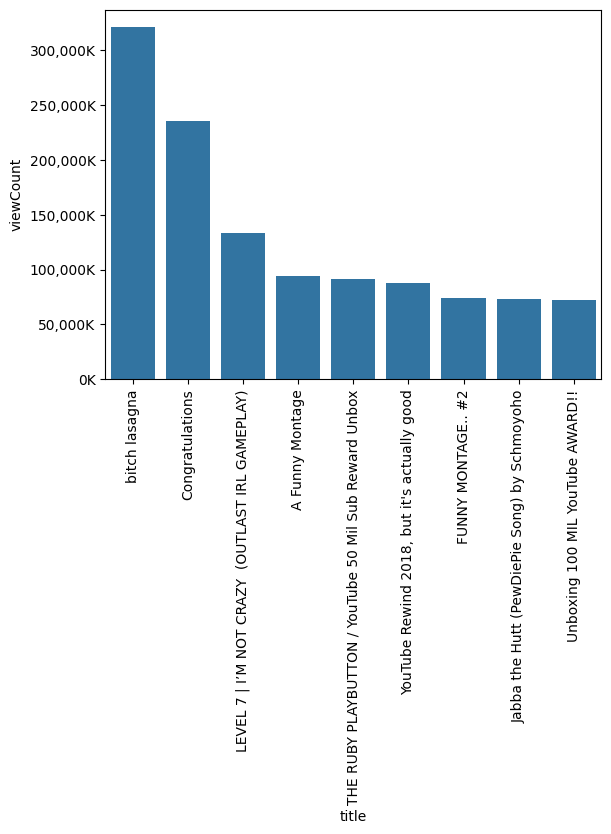

In [81]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## Worst Performing Videos

C:\Users\Rafael\AppData\Local\Temp\ipykernel_6892\171811544.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


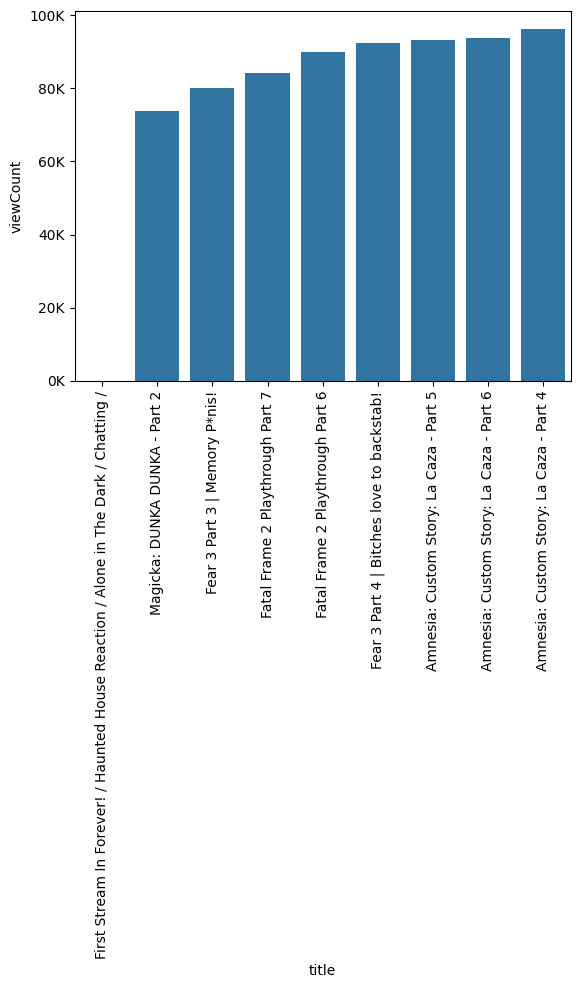

In [82]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## Upload Schedule

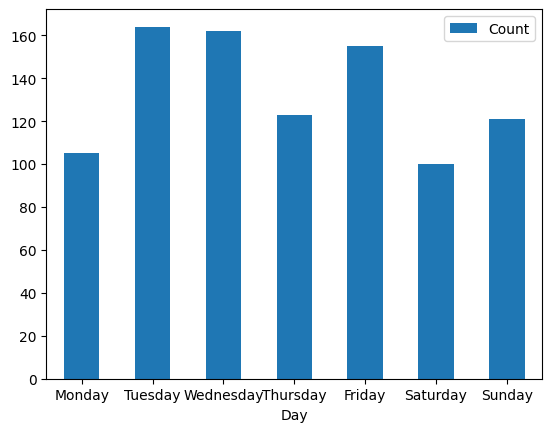

In [51]:
# Create a DataFrame with the count of video publish days
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())

# Correct the typo in 'pushblishDayName' to 'publishDayName'
# Reindex to include all days of the week, filling missing values with 0
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays, fill_value=0)

# Rename the column for better clarity
day_df.columns = ['publishCount']

# Reset index to have the day names as a column
day_df = day_df.reset_index()
day_df.columns = ['Day', 'Count']

# Plot the DataFrame
ax = day_df.plot.bar(x='Day', y='Count', rot=0)


## Word Cloud

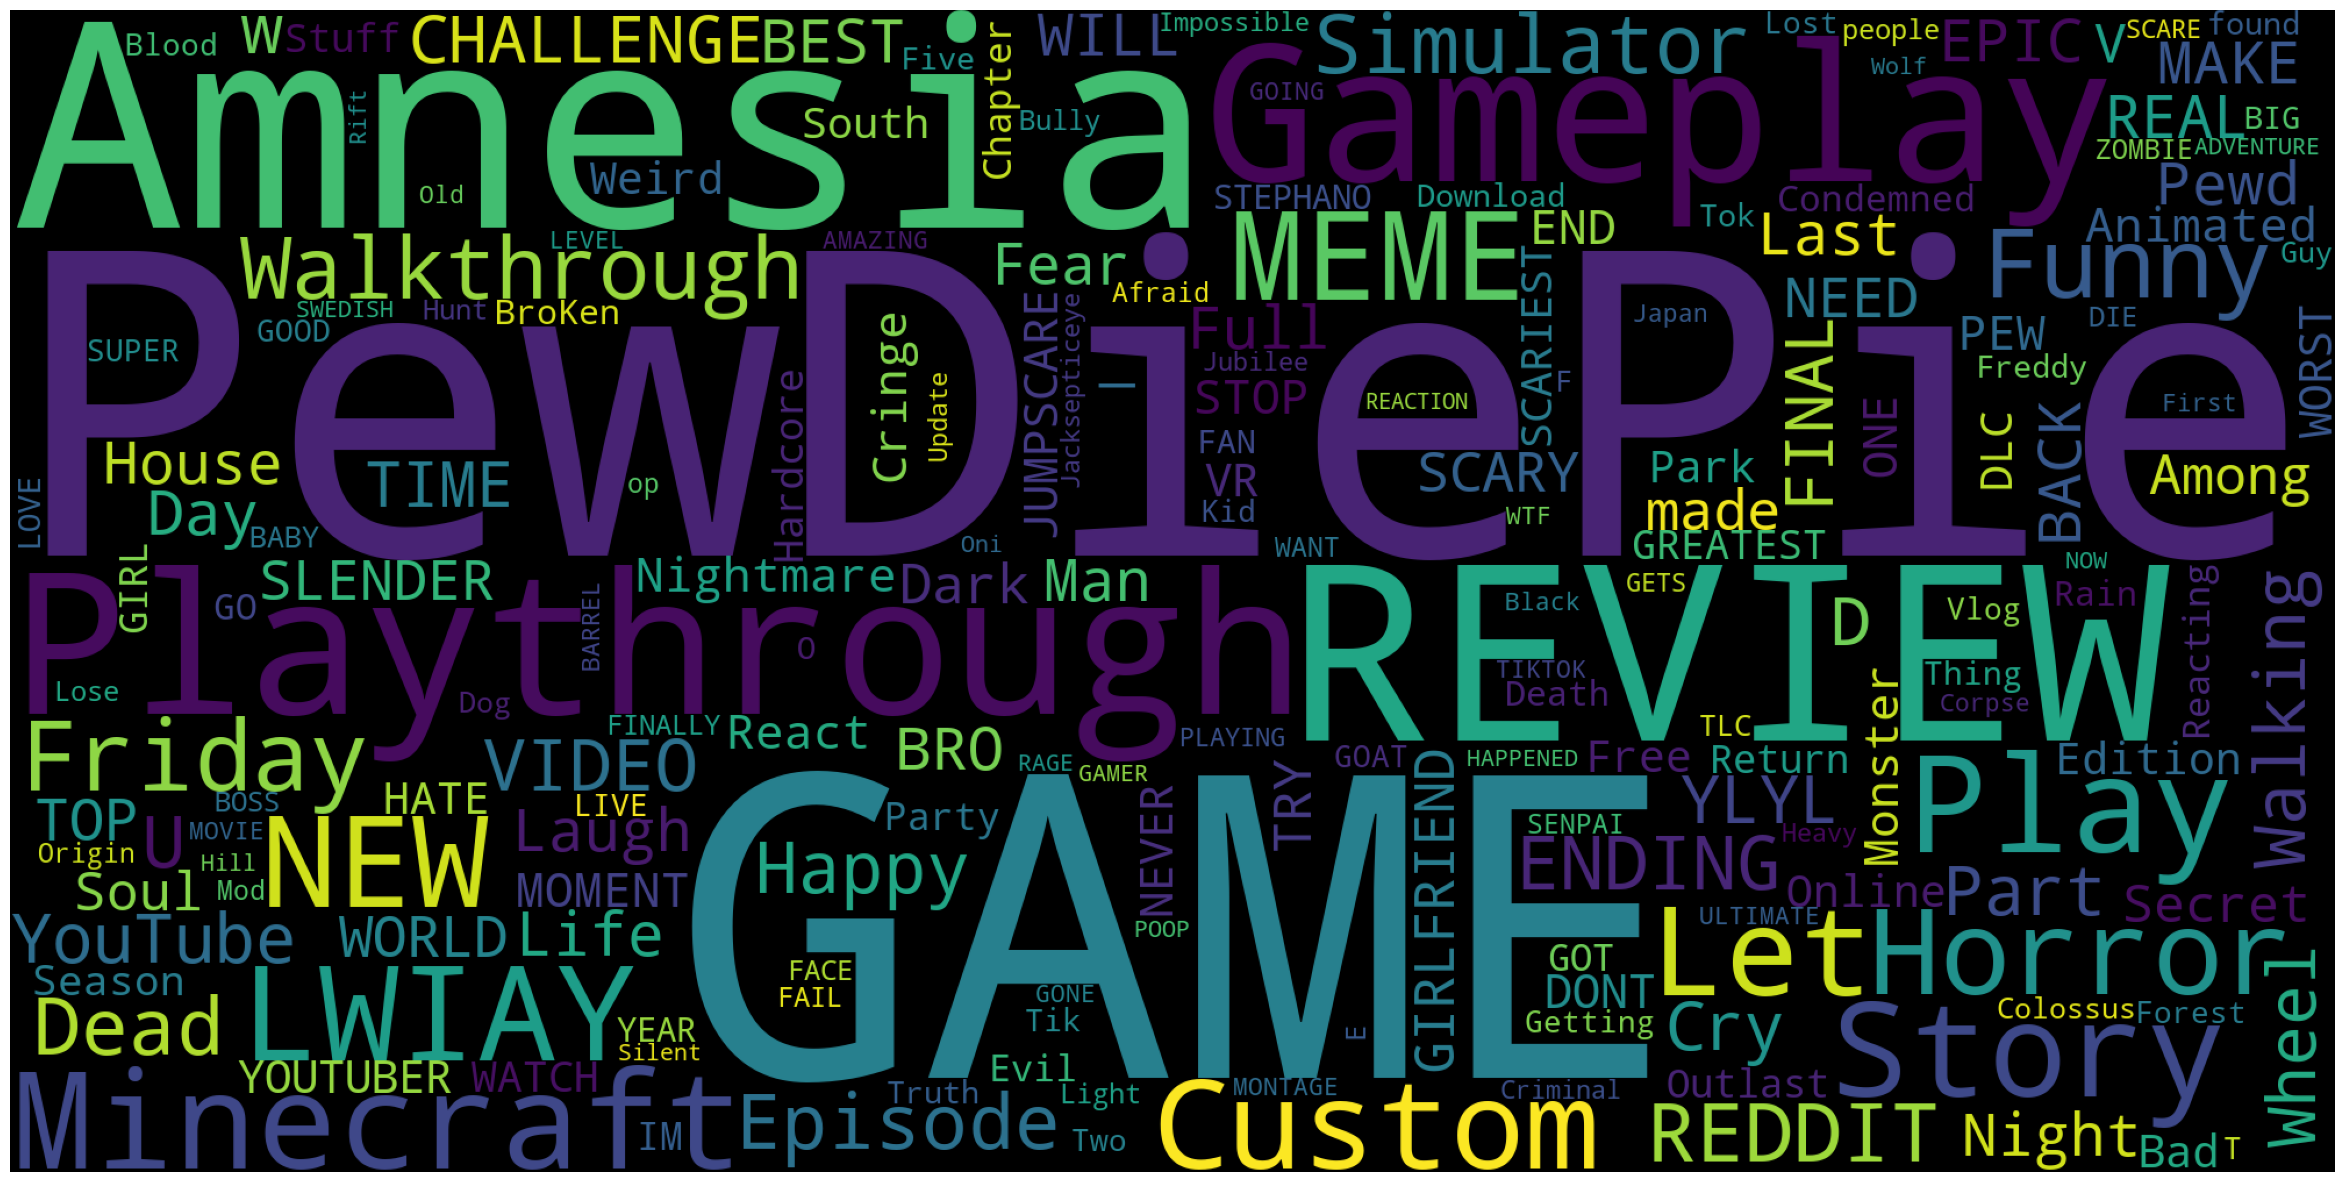

In [87]:
'''
Uses the stopwords module from the nltk.corpus to get a list of common English stop words.
Converts the list of stop words into a set for faster lookup. 
Stop words are common words (like "and", "the", "is") that are often removed from text data to focus on more meaningful words.
'''

stop_words = set(stopwords.words('english'))
stop_words.add('Part') # Add this to stop words because Part word always in every caption pewdiepie videos
# Collect all the words uses in every caption
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b]) # List all the words collected from each video
all_words_str = ' '.join(all_words) # Join Words into a Single String

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off")

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)